Kütüphaneler

In [6]:
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.metrics import *
from fastai.vision.data import *
from pathlib import Path
from fastai.callback import *
import fastai

In [7]:
print(torch.__version__)

1.11.0


In [8]:
print(fastai.__version__)

2.6.3


Veri Hazırlama

In [9]:
path = Path("../../veriler/fastai_f1")
path

Path('../../veriler/fastai_f1')

In [10]:
data = ImageDataLoaders.from_folder(path, train="train", valid="valid", test="test", bs=8, item_tfms=Resize(28), shuffle=True)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


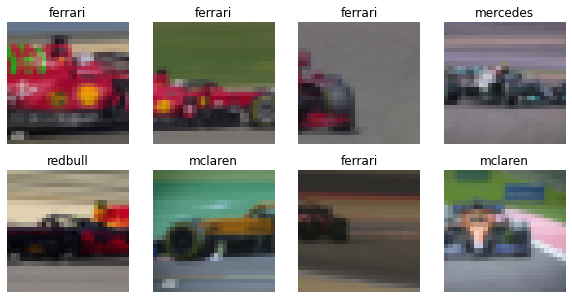

In [11]:
data.show_batch(figsize=(10,5) )

Modelin Oluşumu ve Eğitimi

In [12]:
model = nn.Sequential(
    nn.Conv2d(3, 4, kernel_size=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(4, 8, kernel_size=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(8, 16, kernel_size=(2,2)),
    nn.ReLU(),
    nn.Flatten(),

    nn.Linear(400,200),
    nn.Linear(200,50),
    nn.ReLU(),
    nn.Linear(50,25),
    nn.ReLU(),
    nn.Linear(25,8),
    nn.Linear(8,4),
    nn.Softmax()

)

In [13]:
model

Sequential(
  (0): Conv2d(3, 4, kernel_size=(2, 2), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=400, out_features=200, bias=True)
  (10): Linear(in_features=200, out_features=50, bias=True)
  (11): ReLU()
  (12): Linear(in_features=50, out_features=25, bias=True)
  (13): ReLU()
  (14): Linear(in_features=25, out_features=8, bias=True)
  (15): Linear(in_features=8, out_features=4, bias=True)
  (16): Softmax(dim=None)
)

In [14]:
learn = Learner(data, model, loss_func=fastai.losses.CrossEntropyLossFlat(), metrics=[accuracy, error_rate], lr=0.0012)

In [15]:
learn.summary()

Sequential (Input shape: 8 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 4 x 27 x 27     
Conv2d                                    52         True      
ReLU                                                           
____________________________________________________________________________
                     8 x 4 x 13 x 13     
MaxPool2d                                                      
____________________________________________________________________________
                     8 x 8 x 12 x 12     
Conv2d                                    136        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 8 x 6 x 6       
MaxPool2d                                                      
____________________________________________________________________________
                     8 x 16 x 5 x 

Eğitim

 - 1. İlk Eğitim 

###### Modeli hızlı ve yüksek doğruluklu eğitmek için büyük ve döngüsel öğrenme oranları kullanır.

In [11]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.387407,1.387370,0.253571,0.746429,00:26
1,1.387380,1.387216,0.250000,0.750000,00:31
2,1.387158,1.386747,0.282143,0.717857,00:27
3,1.387130,1.382374,0.317857,0.682143,00:25
4,1.379144,1.360154,0.310714,0.689286,00:26
5,1.365114,1.318089,0.371429,0.628571,00:24
6,1.340026,1.285579,0.417857,0.582143,00:24
7,1.319603,1.342276,0.360714,0.639286,00:26
8,1.308626,1.318204,0.382143,0.617857,00:27
9,1.294662,1.299749,0.407143,0.592857,00:26


- 2. Normal Eğitim

In [12]:
learn.fit(20, 0.0012)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.284782,1.256715,0.410714,0.589286,00:27
1,1.268050,1.244237,0.425000,0.575000,00:25
2,1.250778,1.237588,0.446429,0.553571,00:23
3,1.248590,1.228100,0.464286,0.535714,00:25
4,1.256800,1.254489,0.457143,0.542857,00:25
5,1.253520,1.213593,0.507143,0.492857,00:24
6,1.239659,1.214104,0.478571,0.521429,00:25
7,1.228058,1.222548,0.492857,0.507143,00:24
8,1.222725,1.189822,0.532143,0.467857,00:21
9,1.193605,1.143097,0.607143,0.392857,00:25


- 3. Fine Tune

In [13]:
learn.fine_tune(20,freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.995862,0.973765,0.796429,0.203571,00:18
1,0.996299,0.979678,0.771429,0.228571,00:18
2,1.000954,1.052156,0.678571,0.321429,00:18
3,1.061305,1.068335,0.660714,0.339286,00:18
4,1.100234,0.985769,0.753571,0.246429,00:18


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.974057,0.974746,0.760714,0.239286,00:18
1,0.993576,0.953984,0.789286,0.210714,00:19
2,0.998210,1.020730,0.717857,0.282143,00:18
3,1.002794,0.987361,0.760714,0.239286,00:18
4,0.995749,0.968661,0.775000,0.225000,00:18
5,1.009483,1.025920,0.714286,0.285714,00:19
6,1.004051,0.933306,0.803571,0.196429,00:19
7,0.977617,0.945988,0.803571,0.196429,00:19
8,0.977021,0.911633,0.828571,0.171429,00:18
9,0.989105,1.037678,0.700000,0.300000,00:18


Test

In [11]:
learn.validate()

(#3) [1.3868049383163452,0.25,0.75]

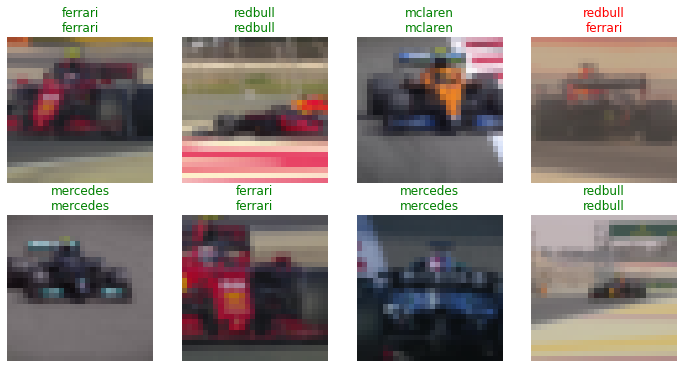

In [15]:
learn.show_results()

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

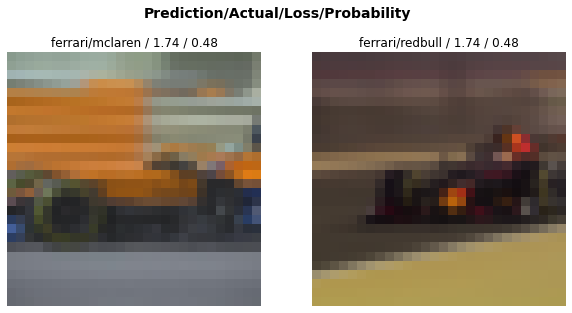

In [17]:
interp.plot_top_losses(2, figsize=(10,5))

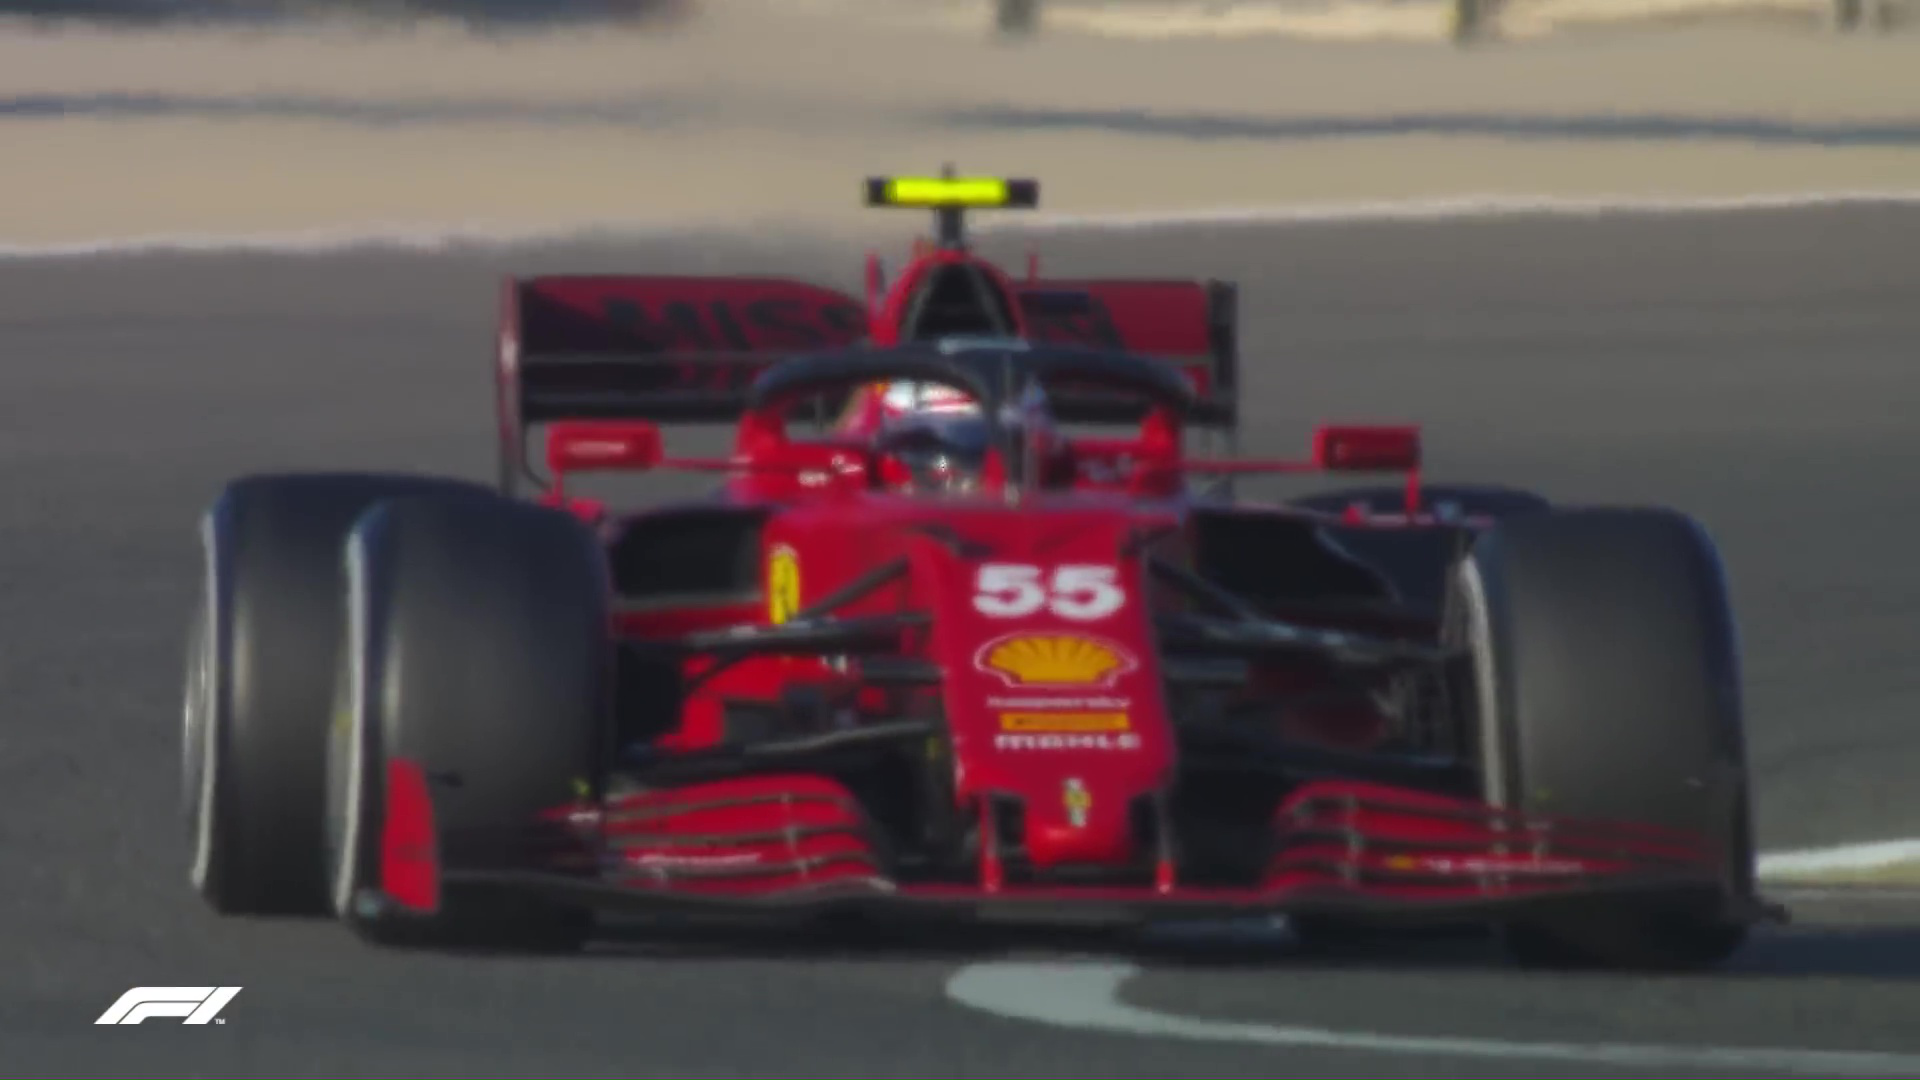

In [18]:
img = data.valid_ds[9][0]
img

In [19]:
learn.predict(img)

('ferrari', TensorImage(0), TensorImage([0.4754, 0.1749, 0.1749, 0.1749]))

Learning rate oranını bulma

Bulduğumuz learning rate ile model yeniden test edildi.

SuggestedLRs(valley=0.0004786300996784121)

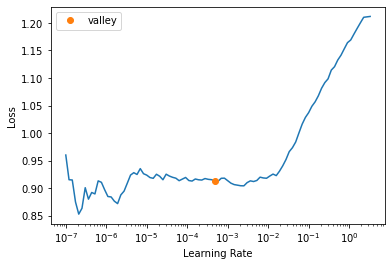

In [20]:
learn.lr_find()

In [21]:
learn.export(fname="fastai_model.pk1")

In [16]:
model = load_learner("../../veriler/fastai_f1/fastai_model.pk1")
model

('ferrari', TensorImage(0), TensorImage([0.4754, 0.1749, 0.1749, 0.1749]))

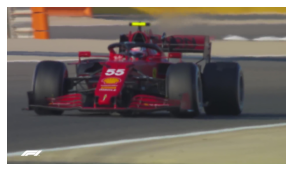

In [17]:
image = data.valid_ds[7][0]
show_image(image)
model.predict(image)

('ferrari', TensorImage(0), TensorImage([0.4754, 0.1749, 0.1749, 0.1749]))

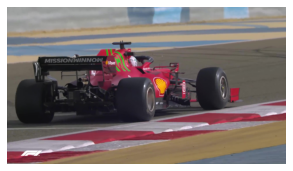

In [18]:
image = data.valid_ds[37][0]
show_image(image)
model.predict(image)

In [19]:
path = Path("../Images/f1.jpg")
model.predict(path)

('mercedes', TensorImage(2), TensorImage([0.1750, 0.1752, 0.4749, 0.1750]))

Hata Temizleme

In [20]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner( learn)
cleaner

In [21]:
for idx, f1 in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), str(path/f1).split(".")[0]+ "_formula.jpg")


Depoy

In [22]:
from fastai.vision.widgets import *
upload = widgets.FileUpload()
out = widgets.Output()
pred1 = widgets.Label()

In [25]:
def data_on(change):
    pred1.value=""
    img = PILImage.create(upload.data[-1])
    out.clear_output()

    with out:
        display(img.to_thumb(224,224))

    pred, pred_idx, probs = model.predict(img) 
    pred1.value = f"tahmin : {pred}; Olasılık : {probs[pred_idx]:.04f}"    

In [26]:
upload.observe(data_on, names=["data"])
display(VBox([widgets.Label("Fotoğraf seç"), upload, out, pred1]))